In [1]:
import sys, os
import psycopg2
import itertools


try:
    from utils.dataset_utils import DatasetUtils
except:
    sys.path.append(os.path.realpath('../'))
    from utils.dataset_utils import DatasetUtils

import json
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
plt.style.use("ggplot")


In [96]:
df = pd.read_csv('../notebook_bo3/dataset/bo3_tdrive.csv', encoding='utf8', converters={'routes':eval, 'regions':eval})
df

,vehicle_id,p_start,p_temp,p_end,routes,regions
0,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7666, 39.8027)","[Empty, Empty, Empty]","[Dianzhuang Tongzhou District, Dianzhuang Tong..."
1,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7666, 39.8027)","[Empty, Empty, Empty]","[Dianzhuang Tongzhou District, Dianzhuang Tong..."
2,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7666, 39.8027)","[Empty, Empty, Empty]","[Dianzhuang Tongzhou District, Dianzhuang Tong..."
3,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7522, 39.80078)","[Empty, Empty, Empty]","[Dianzhuang Tongzhou District, Dianzhuang Tong..."
4,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.72105, 39.81482000000001)","[Empty, Empty, X005]","[Dianzhuang Tongzhou District, Dianzhuang Tong..."
...,...,...,...,...,...,...
970195,702,"(116.34393, 39.96641)","(116.3009, 39.96025)","(116.31725, 39.95593)","[North 3rd Ring Road, Chang Chun Qiao Road, So...","[None Haidian District, 兰靛厂村 Haidian District,..."
970196,702,"(116.29485, 39.95866)","(116.28478, 39.95682)","(116.3009, 39.96025)","[Chang Chun Qiao Road, 蓝靛厂东路, Chang Chun Qiao ...","[兰靛厂村 Haidian District, 兰靛厂村 Haidian District,..."
970197,702,"(116.29485, 39.95866)","(116.28478, 39.95682)","(116.31725, 39.95593)","[Chang Chun Qiao Road, 蓝靛厂东路, South Zhongguanc...","[兰靛厂村 Haidian District, 兰靛厂村 Haidian District,..."
970198,702,"(116.29485, 39.95866)","(116.3009, 39.96025)","(116.31725, 39.95593)","[Chang Chun Qiao Road, Chang Chun Qiao Road, S...","[兰靛厂村 Haidian District, 兰靛厂村 Haidian District,..."


In [97]:
import re

def preprocess(sent):
    
    res = []

    def rpl_space_to_underscore(txt):
        return txt.replace(" ", "_")

    for t in sent:
        try:
            t = t.lower()
            t = re.sub(' road', '', t)
            t = re.sub(' district', '', t)
            t = rpl_space_to_underscore(t)
            res.append(t)
        except Exception as e:
            print(e)

#     return ' '.join(res)
    return res

In [98]:
df['pre_routes'] = df['routes'].apply(lambda x: preprocess(x))
df['pre_regions'] = df['regions'].apply(lambda x: preprocess(x))

In [99]:
origin_df = df.copy()

In [100]:
routes = df['pre_routes'].tolist()
tuple_t = [tuple(item) for item in routes]
t_counts = collections.Counter(tuple_t)
t_counts.most_common(20)

[(('empty', 'empty', 'empty'), 40460),
 (('empty', 'empty', '张采路'), 13845),
 (('empty', '张采路', 'empty'), 7120),
 (('empty', 'empty', 'jianguo'), 5310),
 (('张采路', 'empty', 'empty'), 3815),
 (('empty', 'empty', 'chaoyang'), 3540),
 (('x005', 'empty', 'empty'), 3490),
 (('empty', '张采路', '张采路'), 3040),
 (('何牌路', 'empty', 'empty'), 2863),
 (('京塘路', 'empty', 'empty'), 2850),
 (('santaishan', 'santaishan', 'empty'), 2447),
 (('empty', 'empty', 'north_3rd_ring'), 2412),
 (('santaishan', 'santaishan', 'santaishan'), 2300),
 (('empty', 'empty', '京塘路'), 2142),
 (('empty', '京塘路', 'empty'), 2088),
 (('empty', 'x005', 'empty'), 1870),
 (('empty', 'empty', '中山大街'), 1770),
 (('empty', 'empty', '通惠北路'), 1770),
 (('empty', '张采路', 'jianguo'), 1770),
 (('empty', 'empty', 'x005'), 1720)]

In [101]:
df = pd.DataFrame(t_counts.most_common(),columns=['feature', 'count'])
df.head(20)

,feature,count
0,"(empty, empty, empty)",40460
1,"(empty, empty, 张采路)",13845
2,"(empty, 张采路, empty)",7120
3,"(empty, empty, jianguo)",5310
4,"(张采路, empty, empty)",3815
5,"(empty, empty, chaoyang)",3540
6,"(x005, empty, empty)",3490
7,"(empty, 张采路, 张采路)",3040
8,"(何牌路, empty, empty)",2863
9,"(京塘路, empty, empty)",2850


In [102]:
print(df['count'].describe())
df.sort_values(by=['count'], ascending=False)

count    160024.000000
mean          6.062841
std         114.695613
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max       40460.000000
Name: count, dtype: float64


,feature,count
0,"(empty, empty, empty)",40460
1,"(empty, empty, 张采路)",13845
2,"(empty, 张采路, empty)",7120
3,"(empty, empty, jianguo)",5310
4,"(张采路, empty, empty)",3815
...,...,...
118732,"(wenhuayuan_xilu, 西直门外大街, sanlihe)",1
118733,"(wenhuayuan_xilu, 西直门外大街, 车公庄大街)",1
118734,"(wenhuayuan_xilu, 西直门外大街, n._xisi_8th_alley)",1
118735,"(wenhuayuan_xilu, 西直门外大街, n._xihuangchenggen_str)",1


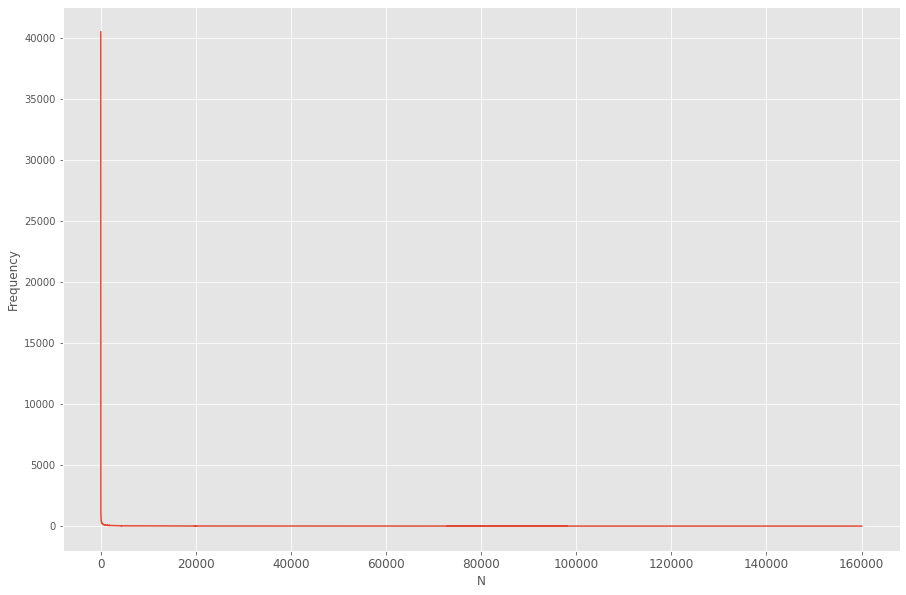

In [103]:
plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.rcParams['xtick.labelsize'] = 12
df.sort_values(by=['count'],ascending=False).plot(legend=None)
# plt.plot(300000,250/2)
plt.xlabel('N')
plt.ylabel('Frequency')
plt.show()

In [104]:
max(df['count'].values), min(df['count'].values), df['count'].values.mean(), np.median(df['count'].unique())

(40460, 1, 6.062840573913913, 191.5)

In [105]:
uni = df['count'].unique()
hist = {}
for i in uni:
    hist.update({i:len(df[df['count']==i])})

# pd.DataFrame.from_dict(hist, columns=['count','frequency'])
freq_count = pd.DataFrame.from_dict(hist, orient='index',columns=['frequency'])
freq_count

,frequency
40460,1
13845,1
7120,1
5310,1
3815,1
...,...
5,2715
4,12355
3,15230
2,37930


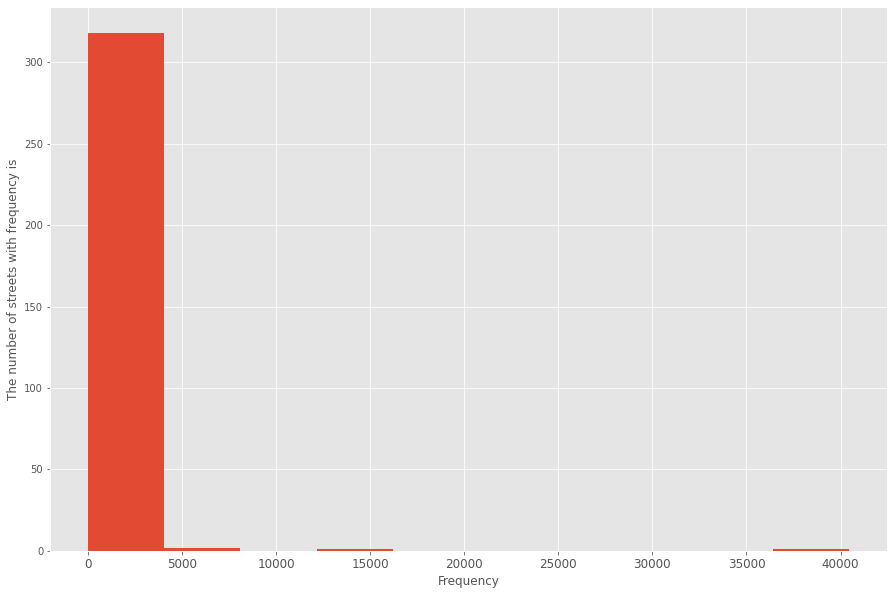

In [106]:
plt.hist(hist)
plt.xlabel('Frequency')
plt.ylabel('The number of streets with frequency is')
plt.show()

In [107]:
df[df['count']==1]

,feature,count
98083,"(x005, x005, binhe_middle)",1
98084,"(x005, x005, 通顺路)",1
98085,"(x005, x005, 玉带河东街)",1
98086,"(x005, x005, yunhe_east_street)",1
98087,"(x005, x005, 通济路)",1
...,...,...
160019,"(south_zhongguancun_street, 蓝靛厂东路, south_zhong...",1
160020,"(chang_chun_qiao, 蓝靛厂东路, chang_chun_qiao)",1
160021,"(chang_chun_qiao, 蓝靛厂东路, south_zhongguancun_st...",1
160022,"(chang_chun_qiao, chang_chun_qiao, south_zhong...",1


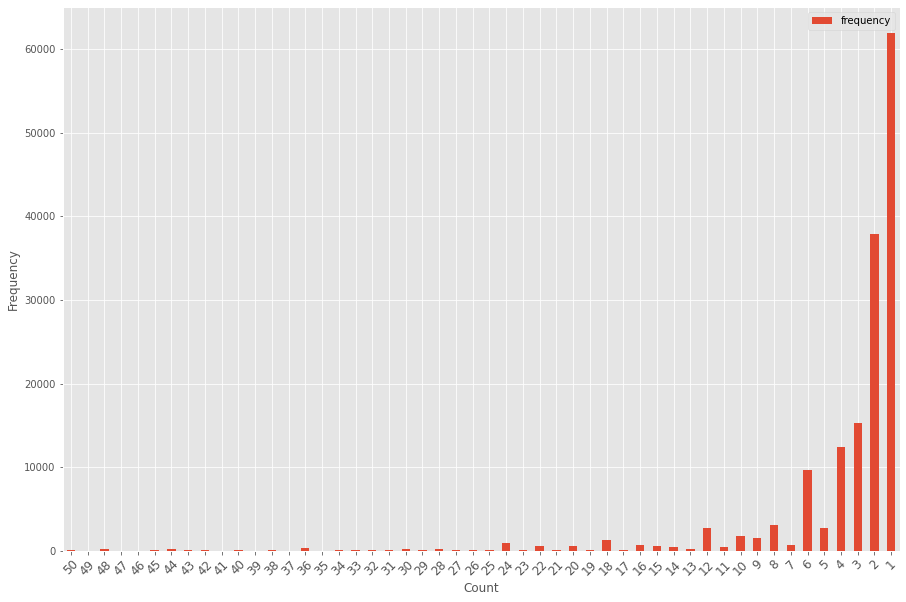

In [108]:
# freq_count.tail(50).sort_values('frequency',ascending=False).plot.bar()
freq_count.tail(50).plot.bar()
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

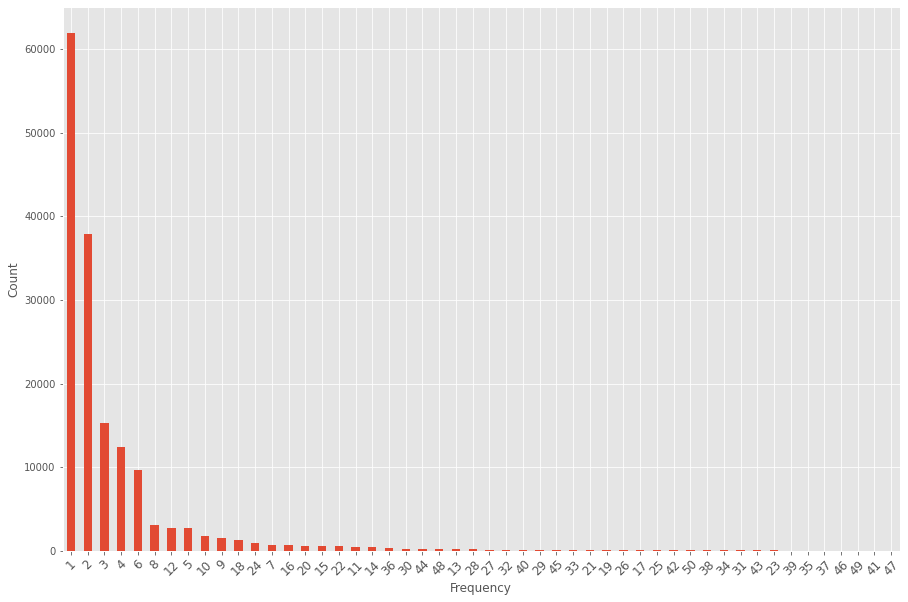

In [109]:
freq_count.tail(50).sort_values('frequency',ascending=False).plot.bar(legend=None)
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [115]:
thres_normal = 30
normal_df = df[df['count']>=thres_normal]
abnormal_df = df[(df['count']>=9) & (df['count']<=10)] # [5,12] (10,15)
print("Normal: ",normal_df.shape[0])
print("Abnormal: ",abnormal_df.shape[0])
print("Total: ",normal_df.shape[0]+abnormal_df.shape[0])

Normal:  3805
Abnormal:  3351
Total:  7156


In [111]:
3351/7156

0.46827836780324206

In [ ]:
abnormal_df['label']=True
normal_df['label']=False

In [122]:
origin_df = origin_df.drop(columns=['routes', 'regions'])

In [131]:
X = origin_df.copy()
X['pre_routes'] = X['pre_routes'].apply(lambda x: tuple(x))
X['pre_regions'] = X['pre_regions'].apply(lambda x: tuple(x))
X

,vehicle_id,p_start,p_temp,p_end,pre_routes,pre_regions
0,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7666, 39.8027)","(empty, empty, empty)","(dianzhuang_tongzhou, dianzhuang_tongzhou, dia..."
1,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7666, 39.8027)","(empty, empty, empty)","(dianzhuang_tongzhou, dianzhuang_tongzhou, dia..."
2,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7666, 39.8027)","(empty, empty, empty)","(dianzhuang_tongzhou, dianzhuang_tongzhou, dia..."
3,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7522, 39.80078)","(empty, empty, empty)","(dianzhuang_tongzhou, dianzhuang_tongzhou, zho..."
4,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.72105, 39.81482000000001)","(empty, empty, x005)","(dianzhuang_tongzhou, dianzhuang_tongzhou, dax..."
...,...,...,...,...,...,...
970195,702,"(116.34393, 39.96641)","(116.3009, 39.96025)","(116.31725, 39.95593)","(north_3rd_ring, chang_chun_qiao, south_zhongg...","(none_haidian, 兰靛厂村_haidian, wanliu_haidian)"
970196,702,"(116.29485, 39.95866)","(116.28478, 39.95682)","(116.3009, 39.96025)","(chang_chun_qiao, 蓝靛厂东路, chang_chun_qiao)","(兰靛厂村_haidian, 兰靛厂村_haidian, 兰靛厂村_haidian)"
970197,702,"(116.29485, 39.95866)","(116.28478, 39.95682)","(116.31725, 39.95593)","(chang_chun_qiao, 蓝靛厂东路, south_zhongguancun_st...","(兰靛厂村_haidian, 兰靛厂村_haidian, wanliu_haidian)"
970198,702,"(116.29485, 39.95866)","(116.3009, 39.96025)","(116.31725, 39.95593)","(chang_chun_qiao, chang_chun_qiao, south_zhong...","(兰靛厂村_haidian, 兰靛厂村_haidian, wanliu_haidian)"


In [142]:
X = X.drop_duplicates('pre_routes')
X

,vehicle_id,p_start,p_temp,p_end,pre_routes,pre_regions
0,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7666, 39.8027)","(empty, empty, empty)","(dianzhuang_tongzhou, dianzhuang_tongzhou, dia..."
4,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.72105, 39.81482000000001)","(empty, empty, x005)","(dianzhuang_tongzhou, dianzhuang_tongzhou, dax..."
5,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.70168, 39.8301)","(empty, empty, 何牌路)","(dianzhuang_tongzhou, dianzhuang_tongzhou, pai..."
16,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.77232, 39.81688)","(empty, empty, 京塘路)","(dianzhuang_tongzhou, dianzhuang_tongzhou, lia..."
18,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.68455, 39.90142)","(empty, empty, binhe_middle)","(dianzhuang_tongzhou, dianzhuang_tongzhou, qia..."
...,...,...,...,...,...,...
970033,702,"(116.34378, 39.96626)","(116.28478, 39.95682)","(116.31725, 39.95593)","(north_3rd_ring, 蓝靛厂东路, south_zhongguancun_str...","(none_haidian, 兰靛厂村_haidian, wanliu_haidian)"
970196,702,"(116.29485, 39.95866)","(116.28478, 39.95682)","(116.3009, 39.96025)","(chang_chun_qiao, 蓝靛厂东路, chang_chun_qiao)","(兰靛厂村_haidian, 兰靛厂村_haidian, 兰靛厂村_haidian)"
970197,702,"(116.29485, 39.95866)","(116.28478, 39.95682)","(116.31725, 39.95593)","(chang_chun_qiao, 蓝靛厂东路, south_zhongguancun_st...","(兰靛厂村_haidian, 兰靛厂村_haidian, wanliu_haidian)"
970198,702,"(116.29485, 39.95866)","(116.3009, 39.96025)","(116.31725, 39.95593)","(chang_chun_qiao, chang_chun_qiao, south_zhong...","(兰靛厂村_haidian, 兰靛厂村_haidian, wanliu_haidian)"


In [143]:
def find_freq_of_route(x, df_freq):
    return df[df['feature']==x]['count'].tolist()[0]

X['freq'] = X['pre_routes'].apply(lambda street: find_freq_of_route(street,df))
X

,vehicle_id,p_start,p_temp,p_end,pre_routes,pre_regions,freq
0,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7666, 39.8027)","(empty, empty, empty)","(dianzhuang_tongzhou, dianzhuang_tongzhou, dia...",40460
4,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.72105, 39.81482000000001)","(empty, empty, x005)","(dianzhuang_tongzhou, dianzhuang_tongzhou, dax...",1720
5,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.70168, 39.8301)","(empty, empty, 何牌路)","(dianzhuang_tongzhou, dianzhuang_tongzhou, pai...",1683
16,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.77232, 39.81688)","(empty, empty, 京塘路)","(dianzhuang_tongzhou, dianzhuang_tongzhou, lia...",2142
18,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.68455, 39.90142)","(empty, empty, binhe_middle)","(dianzhuang_tongzhou, dianzhuang_tongzhou, qia...",91
...,...,...,...,...,...,...,...
970033,702,"(116.34378, 39.96626)","(116.28478, 39.95682)","(116.31725, 39.95593)","(north_3rd_ring, 蓝靛厂东路, south_zhongguancun_str...","(none_haidian, 兰靛厂村_haidian, wanliu_haidian)",5
970196,702,"(116.29485, 39.95866)","(116.28478, 39.95682)","(116.3009, 39.96025)","(chang_chun_qiao, 蓝靛厂东路, chang_chun_qiao)","(兰靛厂村_haidian, 兰靛厂村_haidian, 兰靛厂村_haidian)",1
970197,702,"(116.29485, 39.95866)","(116.28478, 39.95682)","(116.31725, 39.95593)","(chang_chun_qiao, 蓝靛厂东路, south_zhongguancun_st...","(兰靛厂村_haidian, 兰靛厂村_haidian, wanliu_haidian)",1
970198,702,"(116.29485, 39.95866)","(116.3009, 39.96025)","(116.31725, 39.95593)","(chang_chun_qiao, chang_chun_qiao, south_zhong...","(兰靛厂村_haidian, 兰靛厂村_haidian, wanliu_haidian)",1


In [144]:
X.to_csv('../dataset/raw_bo3_tdrive.csv', encoding='utf-8', index=False)

In [ ]:
thres_normal = 30
normal_df = df[df['count']>=thres_normal]
abnormal_df = df[(df['count']>=9) & (df['count']<=10)] # [5,12] (10,15)
abnormal_df['label']=True
normal_df['label']=False
normal_df.shape, abnormal_df.shape

In [ ]:
abnormal_df

In [ ]:
normal_df

In [140]:
X1 = normal_df.copy()
X = X.append(abnormal_df) 

,vehicle_id,p_start,p_temp,p_end,pre_routes,pre_regions
0,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7666, 39.8027)","(empty, empty, empty)","(dianzhuang_tongzhou, dianzhuang_tongzhou, dia..."
4,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.72105, 39.81482000000001)","(empty, empty, x005)","(dianzhuang_tongzhou, dianzhuang_tongzhou, dax..."
5,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.70168, 39.8301)","(empty, empty, 何牌路)","(dianzhuang_tongzhou, dianzhuang_tongzhou, pai..."
16,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.77232, 39.81688)","(empty, empty, 京塘路)","(dianzhuang_tongzhou, dianzhuang_tongzhou, lia..."
18,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.68455, 39.90142)","(empty, empty, binhe_middle)","(dianzhuang_tongzhou, dianzhuang_tongzhou, qia..."
...,...,...,...,...,...,...
970033,702,"(116.34378, 39.96626)","(116.28478, 39.95682)","(116.31725, 39.95593)","(north_3rd_ring, 蓝靛厂东路, south_zhongguancun_str...","(none_haidian, 兰靛厂村_haidian, wanliu_haidian)"
970196,702,"(116.29485, 39.95866)","(116.28478, 39.95682)","(116.3009, 39.96025)","(chang_chun_qiao, 蓝靛厂东路, chang_chun_qiao)","(兰靛厂村_haidian, 兰靛厂村_haidian, 兰靛厂村_haidian)"
970197,702,"(116.29485, 39.95866)","(116.28478, 39.95682)","(116.31725, 39.95593)","(chang_chun_qiao, 蓝靛厂东路, south_zhongguancun_st...","(兰靛厂村_haidian, 兰靛厂村_haidian, wanliu_haidian)"
970198,702,"(116.29485, 39.95866)","(116.3009, 39.96025)","(116.31725, 39.95593)","(chang_chun_qiao, chang_chun_qiao, south_zhong...","(兰靛厂村_haidian, 兰靛厂村_haidian, wanliu_haidian)"


In [3]:
data = pd.read_csv('../dataset/raw_bo3_tdrive.csv', encoding='utf-8')

In [4]:
data

,vehicle_id,p_start,p_temp,p_end,pre_routes,pre_regions,freq
0,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7666, 39.8027)","('empty', 'empty', 'empty')","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",40460
1,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.72105, 39.81482000000001)","('empty', 'empty', 'x005')","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",1720
2,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.70168, 39.8301)","('empty', 'empty', '何牌路')","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",1683
3,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.77232, 39.81688)","('empty', 'empty', '京塘路')","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",2142
4,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.68455, 39.90142)","('empty', 'empty', 'binhe_middle')","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",91
...,...,...,...,...,...,...,...
160019,702,"(116.34378, 39.96626)","(116.28478, 39.95682)","(116.31725, 39.95593)","('north_3rd_ring', '蓝靛厂东路', 'south_zhongguancu...","('none_haidian', '兰靛厂村_haidian', 'wanliu_haidi...",5
160020,702,"(116.29485, 39.95866)","(116.28478, 39.95682)","(116.3009, 39.96025)","('chang_chun_qiao', '蓝靛厂东路', 'chang_chun_qiao')","('兰靛厂村_haidian', '兰靛厂村_haidian', '兰靛厂村_haidian')",1
160021,702,"(116.29485, 39.95866)","(116.28478, 39.95682)","(116.31725, 39.95593)","('chang_chun_qiao', '蓝靛厂东路', 'south_zhongguanc...","('兰靛厂村_haidian', '兰靛厂村_haidian', 'wanliu_haidi...",1
160022,702,"(116.29485, 39.95866)","(116.3009, 39.96025)","(116.31725, 39.95593)","('chang_chun_qiao', 'chang_chun_qiao', 'south_...","('兰靛厂村_haidian', '兰靛厂村_haidian', 'wanliu_haidi...",1


In [5]:
data['pre_routes'][0]

"('empty', 'empty', 'empty')"

In [6]:
normal_df = data[data['freq']>=30]
abnormal_df = data[(data['freq']>=9) & (data['freq']<=10)]

In [7]:
abnormal_df['label']=True
normal_df['label']=False

<ipython-input-7-2b6ea3b23927>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abnormal_df['label']=True
<ipython-input-7-2b6ea3b23927>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_df['label']=False


In [9]:
normal_df

,vehicle_id,p_start,p_temp,p_end,pre_routes,pre_regions,freq,label
0,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7666, 39.8027)","('empty', 'empty', 'empty')","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",40460,False
1,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.72105, 39.81482000000001)","('empty', 'empty', 'x005')","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",1720,False
2,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.70168, 39.8301)","('empty', 'empty', '何牌路')","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",1683,False
3,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.77232, 39.81688)","('empty', 'empty', '京塘路')","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",2142,False
4,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.68455, 39.90142)","('empty', 'empty', 'binhe_middle')","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",91,False
...,...,...,...,...,...,...,...,...
159036,702,"(116.34978, 39.91694)","(116.29608, 39.90652)","(116.34378, 39.96626)","('yuetan_north', 'cuiwei', 'north_3rd_ring')","('none_xicheng', 'none_haidian', 'none_haidian')",40,False
159531,702,"(116.30546, 39.87569000000001)","(116.29608, 39.90652)","(116.34378, 39.96626)","('西三环', 'cuiwei', 'north_3rd_ring')","('太平桥村_fengtai', 'none_haidian', 'none_haidian')",40,False
159766,702,"(116.29608, 39.90652)","(116.29617, 39.90941)","(116.34378, 39.96626)","('cuiwei', 'cuiwei', 'north_3rd_ring')","('none_haidian', 'none_haidian', 'none_haidian')",30,False
159813,702,"(116.29608, 39.90652)","(116.34378, 39.96626)","(116.37373, 39.96672)","('cuiwei', 'north_3rd_ring', 'north_3rd_ring')","('none_haidian', 'none_haidian', 'huayuanlu_su...",40,False


In [10]:
X = normal_df.copy()
X = X.append(abnormal_df)
X

,vehicle_id,p_start,p_temp,p_end,pre_routes,pre_regions,freq,label
0,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7666, 39.8027)","('empty', 'empty', 'empty')","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",40460,False
1,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.72105, 39.81482000000001)","('empty', 'empty', 'x005')","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",1720,False
2,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.70168, 39.8301)","('empty', 'empty', '何牌路')","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",1683,False
3,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.77232, 39.81688)","('empty', 'empty', '京塘路')","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",2142,False
4,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.68455, 39.90142)","('empty', 'empty', 'binhe_middle')","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",91,False
...,...,...,...,...,...,...,...,...
159984,702,"(116.31534, 39.96547)","(116.34378, 39.96626)","(116.37373, 39.96672)","('south_zhongguancun_street', 'north_3rd_ring'...","('wanliu_haidian', 'none_haidian', 'huayuanlu_...",10,True
159987,702,"(116.31534, 39.96547)","(116.34378, 39.96626)","(116.29485, 39.95866)","('south_zhongguancun_street', 'north_3rd_ring'...","('wanliu_haidian', 'none_haidian', '兰靛厂村_haidi...",10,True
160007,702,"(116.34378, 39.96626)","(116.37373, 39.96672)","(116.28478, 39.95682)","('north_3rd_ring', 'north_3rd_ring', '蓝靛厂东路')","('none_haidian', 'huayuanlu_subdistrict_xichen...",10,True
160008,702,"(116.34378, 39.96626)","(116.37373, 39.96672)","(116.31725, 39.95593)","('north_3rd_ring', 'north_3rd_ring', 'south_zh...","('none_haidian', 'huayuanlu_subdistrict_xichen...",10,True


In [11]:
X.to_csv('../dataset/clean_dataset/clean_bo3_tdrive.csv', encoding='utf-8', index=False)